Новая обновлённая нейронка

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Загрузка данных
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# 2. Модель
class BetterNet(nn.Module):
    def __init__(self, activation='relu'):
        super(BetterNet, self).__init__()
        
        self.activation = activation
        
        self.fc1 = nn.Linear(28 * 28, 256)  # больше нейронов
        self.bn1 = nn.BatchNorm1d(256)      # нормализация
        self.dropout1 = nn.Dropout(0.3)     # регуляризация
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)
        
        self.out = nn.Linear(64, 10)  # выходной слой

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        
        x = self._apply_activation(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self._apply_activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self._apply_activation(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.out(x)  # логиты, softmax не нужен если используешь CrossEntropyLoss

    def _apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        else:
            return x


# 3. Обучение
def train(model, loader, optimizer, criterion, epochs=100):
    model.train()
    loss_history = []
    accuracy_history = []

    important_epochs = [1, 2, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    full_log = ""

    for epoch in range(1, epochs + 1):
        total_loss = 0
        correct = 0
        total = 0

        for i, (X, y) in enumerate(loader):
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            predicted = torch.argmax(out, dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

            if i == 0:
                first_preds = list(zip(y[:10], predicted[:10]))
            elif i == len(loader) - 1:
                last_preds = list(zip(y[:10], predicted[:10]))

        avg_loss = total_loss / len(loader)
        accuracy = correct / total
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        # 🔍 Валидация
        val_loss = 0
        val_correct = 0
        val_total = 0

        model.eval()
        with torch.no_grad():
            for X_val, y_val in test_loader:
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == y_val).sum().item()
                val_total += y_val.size(0)
        model.train()

        val_loss /= len(test_loader)
        val_acc = val_correct / val_total

        # 🖨 Лог на каждую эпоху
        full_log += f"Epoch {epoch} — Train Loss: {avg_loss:.4f} | Train Acc: {accuracy * 100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%\n"


        # Подробный лог на ключевых эпохах
        if epoch in important_epochs:
            full_log += "\nПервые 10 предсказаний:\n"
            for real, pred in first_preds:
                full_log += f"  Правильный = {real.item()} \t Предсказание = {pred.item()}\n"
            full_log += "\nПоследние 10 предсказаний:\n"
            for real, pred in last_preds:
                full_log += f"  Правильный = {real.item()} \t Предсказание = {pred.item()}\n"
            full_log += "\n" + "-" * 40 + "\n"

    # Печатаем весь лог
    print(full_log)

    # Сохраняем в файл
    with open("train_log.txt", "w", encoding="utf-8") as f:
        f.write(full_log)

    return loss_history, accuracy_history

relu
Epoch 1 — Train Loss: 0.4078 | Train Acc: 89.21% | Val Loss: 0.1214 | Val Acc: 96.32%

Первые 10 предсказаний:
  Правильный = 4 	 Предсказание = 7
  Правильный = 4 	 Предсказание = 1
  Правильный = 1 	 Предсказание = 5
  Правильный = 0 	 Предсказание = 4
  Правильный = 9 	 Предсказание = 1
  Правильный = 2 	 Предсказание = 7
  Правильный = 6 	 Предсказание = 1
  Правильный = 2 	 Предсказание = 5
  Правильный = 6 	 Предсказание = 6
  Правильный = 8 	 Предсказание = 7

Последние 10 предсказаний:
  Правильный = 2 	 Предсказание = 2
  Правильный = 1 	 Предсказание = 1
  Правильный = 8 	 Предсказание = 8
  Правильный = 4 	 Предсказание = 4
  Правильный = 8 	 Предсказание = 8
  Правильный = 4 	 Предсказание = 4
  Правильный = 8 	 Предсказание = 8
  Правильный = 1 	 Предсказание = 1
  Правильный = 5 	 Предсказание = 5
  Правильный = 7 	 Предсказание = 9

----------------------------------------
Epoch 2 — Train Loss: 0.1980 | Train Acc: 94.29% | Val Loss: 0.0982 | Val Acc: 97.11%

Первые 

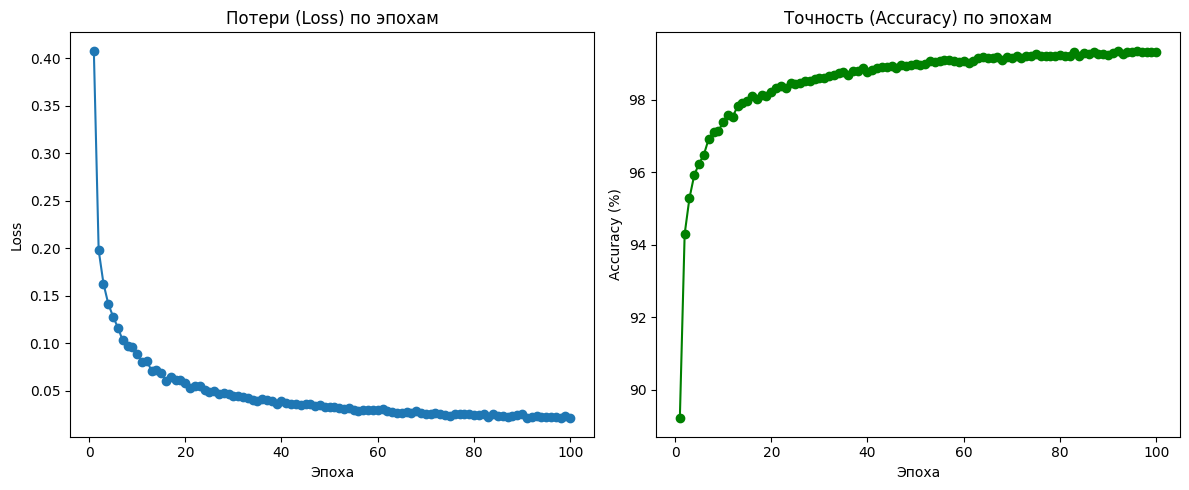

In [6]:
# 4. Запуск модели
print('relu')
model = BetterNet(activation='relu')  # 'relu', 'sigmoid', 'tanh'
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_hist, acc_hist = train(model, train_loader, optimizer, criterion, epochs=100)

# 5. Графики
epochs = range(1, len(loss_hist) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_hist, marker='o')
plt.title("Потери (Loss) по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in acc_hist], marker='o', color='green')
plt.title("Точность (Accuracy) по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.savefig("training_graphs.png")
plt.show()